# Homework 3: optimization of a CNN model
The task of this homework is to optimize a CNN model for the CIFAR-100. You are free to define the architecture of the model, and the training procedure. The only contraints are:
- It must be a `torch.nn.Module` object
- The number of trained parameters must be less than 1 million
- The test dataset must not be used for any step of training.
- The final training notebook should run on Google Colab within a maximum 1 hour approximately.
- Do not modify the random seed, as they are needed for reproducibility purpose.

For the grading, you must use the `evaluate` function defined below. It takes a model as input, and returns the test accuracy as output.

As a guideline, you are expected to **discuss** and motivate your choices regarding:
- Model architecture
- Hyperparameters (learning rate, batch size, etc)
- Regularization methods
- Optimizer
- Validation scheme

A code without any explanation of the choices will not be accepted. Test accuracy is not the only measure of success for this homework.

Remember that most of the train process is randomized, store your model's weights after training and load it before the evaluation!

## Example

### Loading packages and libraries

In [34]:
import random
import numpy as np
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch.nn.functional as F


# Fix all random seeds
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# For full determinism
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Import the best device available
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.mps.is_available() else 'cpu')
print('Using device:', device)

# load the data
train_dataset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=torchvision.transforms.ToTensor())

Using device: cuda


In [35]:
test_dataset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=torchvision.transforms.ToTensor())

def evaluate(model):
    params_count = sum(p.numel() for p in model.parameters())
    print('The model has {} parameters'.format(params_count))

    if params_count > int(1e6):
        print('The model has too many parameters! Not allowed to evaluate.')
        return

    model = model.to(device)
    model.eval()
    correct = 0
    total = 0

    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()


    # print in bold red in a notebook
    print('\033[1m\033[91mAccuracy on the test set: {}%\033[0m'.format(100 * correct / total))


Since we are not allowed to use the test set during development (as expected), we split the available training data into a training subset and a validation subset. This allows us to tune the model and evaluate its generalization during training using the validation set, while keeping the test set untouched for the final evaluation.

In [36]:
# load the train dataset
train_dataset = torchvision.datasets.CIFAR100(
    root='./data/',
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor())

# Split the dataset into 45k-5k samples for training-validation.
from torch.utils.data import random_split
train_dataset,  valid_dataset = random_split(
    train_dataset,
    lengths=[45000, 5000],
    generator=torch.Generator().manual_seed(42) #use a generator to insure reproducibilty
)

# what is the type of the "new" training dataset?
print(train_dataset)


We implement a `fit` function to centralize the full training procedure in one place. It avoids repeating the same training code across experiments and ensures every run follows the same steps (train mode, forward/loss/backprop/update, then optional validation).  

This makes it easier to:
- track and store losses/accuracies per epoch,
- compare different optimizers, learning rates, batch sizes, and architectures fairly,
- detect overfitting early (training improves while validation degrades),
- plug in extras like learning-rate schedulers and early stopping without rewriting the loop each time.

In [68]:
from typing import Optional, Tuple, List
import torch
from torch import nn
from torch.utils.data import DataLoader


from typing import Optional, Tuple, List
import copy
import torch
from torch import nn
from torch.utils.data import DataLoader


def fit(
    model: nn.Module,
    train_dataloader: DataLoader,
    optimizer: torch.optim.Optimizer,
    epochs: int,
    device: torch.device,
    valid_dataloader: Optional[DataLoader] = None,
    criterion: Optional[nn.Module] = None,
    scheduler: Optional[torch.optim.lr_scheduler._LRScheduler] = None,
    early_stopping_patience: int = 10,
    early_stopping_min_delta: float = 1e-4,
    early_stopping_metric: str = "val_acc",  # "val_acc" or "val_loss"
    restore_best_weights: bool = True,
) -> Tuple[List[float], List[float], List[float]]:
    """
    Train loop with optional validation, scheduler, and early stopping.

    Early stopping:
      - metric="val_acc": stop when val acc doesn't improve for `patience` epochs
      - metric="val_loss": stop when val loss doesn't improve for `patience` epochs
    """

    if criterion is None:
        criterion = nn.CrossEntropyLoss()

    model.to(device)

    train_losses: List[float] = []
    valid_losses: List[float] = []
    valid_accs: List[float] = []

    # --- early stopping state ---
    if valid_dataloader is not None:
        if early_stopping_metric not in {"val_acc", "val_loss"}:
            raise ValueError("early_stopping_metric must be 'val_acc' or 'val_loss'")

        best_state = copy.deepcopy(model.state_dict())
        best_epoch = -1
        bad_epochs = 0

        if early_stopping_metric == "val_acc":
            best_score = float("-inf")  # maximize
        else:
            best_score = float("inf")   # minimize
    else:
        best_state = None

    for epoch in range(epochs):
        # ---- TRAIN ----
        model.train()
        running_loss = 0.0
        num_samples = 0

        for images, labels in train_dataloader:
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            optimizer.zero_grad(set_to_none=True)
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            bs = images.size(0)
            running_loss += loss.item() * bs
            num_samples += bs

        train_loss = running_loss / max(1, num_samples)
        train_losses.append(train_loss)

        # ---- VALIDATION ----
        if valid_dataloader is not None:
            valid_loss, valid_acc = predict(model, valid_dataloader, device, verbose=False)
            valid_losses.append(valid_loss)
            valid_accs.append(valid_acc)

            # scheduler step (typical: once per epoch)
            if scheduler is not None:
                # If you use ReduceLROnPlateau, it needs a metric:
                if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                    scheduler.step(valid_loss)
                else:
                    scheduler.step()

            print(
                f"Epoch {epoch}: Train Loss={train_loss:.4f}, "
                f"Validation Loss={valid_loss:.4f}, Validation acc={valid_acc:.4f}"
            )

            # ---- EARLY STOPPING CHECK ----
            if early_stopping_metric == "val_acc":
                current = valid_acc
                improved = current > best_score + early_stopping_min_delta
            else:
                current = valid_loss
                improved = current < best_score - early_stopping_min_delta

            if improved:
                best_score = current
                best_epoch = epoch
                bad_epochs = 0
                if restore_best_weights:
                    best_state = copy.deepcopy(model.state_dict())
            else:
                bad_epochs += 1
                if bad_epochs >= early_stopping_patience:
                    print(
                        f"Early stopping at epoch {epoch}. "
                        f"Best epoch was {best_epoch} with {early_stopping_metric}={best_score:.4f}."
                    )
                    break
        else:
            # scheduler step even without validation (optional)
            if scheduler is not None:
                if not isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                    scheduler.step()
            print(f"Epoch {epoch}: Train Loss={train_loss:.4f}")

    # restore best weights if requested and we had validation
    if valid_dataloader is not None and restore_best_weights and best_state is not None:
        model.load_state_dict(best_state)

    return train_losses, valid_losses, valid_accs

In [38]:
from typing import List, Optional


def plot_losses(
    train_losses: List[float],
    valid_losses: Optional[List[float]] = None,
    title: str = "Loss per epoch",
) -> None:
    """
    Plots training loss (and optional validation loss) vs epoch.

    Usage:
        train_losses, valid_losses, valid_accs = fit(...)
        plot_losses(train_losses, valid_losses)
    """
    epochs = list(range(1, len(train_losses) + 1))

    plt.figure()
    plt.plot(epochs, train_losses, label="train loss")

    if valid_losses is not None and len(valid_losses) > 0:
        # If valid_losses length differs (shouldn't, but safe), align to its length
        v_epochs = list(range(1, len(valid_losses) + 1))
        plt.plot(v_epochs, valid_losses, label="valid loss")

    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(title)
    plt.legend()
    plt.show()

In [39]:
from typing import Tuple
import torch
from torch import nn
from torch.utils.data import DataLoader

"""
Evaluates a classification model and returns:
      - average loss over all samples
      - accuracy over all samples

    Assumes dataloader yields (inputs, labels) and model outputs logits of shape (B, num_classes).
    Uses CrossEntropyLoss by default (standard for CIFAR-100 classification).
    """

@torch.no_grad()
def predict(
    model: nn.Module,
    dataloader: DataLoader,
    device: torch.device,
    verbose: bool = True,
) -> Tuple[float, float]:

    model.eval()
    model.to(device)

    criterion = nn.CrossEntropyLoss(reduction="sum")  # sum to average properly over samples

    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    for images, labels in dataloader:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        outputs = model(images)  # logits
        loss = criterion(outputs, labels)

        total_loss += loss.item()
        preds = outputs.argmax(dim=1)
        total_correct += (preds == labels).sum().item()
        total_samples += labels.size(0)

    avg_loss = total_loss / max(1, total_samples)
    acc = total_correct / max(1, total_samples)

    if verbose:
        print(f"Loss={avg_loss:.4f}, Accuracy={acc:.4f}")

    return avg_loss, acc

## Model Architecture Used  : ResNet

In the lab, we used a ResNet as the final model for CIFAR-10, so we will start from the same baseline here. However, the ResNet used for CIFAR-10 has over 1 million parameters, so we decided to change a bit the architecture first . In fact , the model begins with 64 channels and then increases the width at each stage to 128, 256, and 512 channels. With two 3×3 convolutions per block, most of the parameters come from convolution layers, and the number of convolution parameters scales as $3\cdot 3\cdot C_{in}\cdot C_{out}$. As a result, doubling the number of channels roughly multiplies the parameter count by about four, meaning the later stages (especially the 256→512 part) dominate the total number of parameters.

Since our goal is to train on CIFAR-100 while keeping the model efficient, we decided to reduce the parameter count rather than increasing model capacity further. CIFAR-100 images are only 32×32, and after several downsampling steps the spatial resolution becomes very small (e.g., 8×8 then 4×4). At that point, having 512 channels can be unnecessarily expensive: it increases computation and memory usage and can also increase the risk of overfitting without guaranteeing better generalization.

Therefore, we redesigned the network by reducing the width (for example starting at 32 instead of 64) and/or capping the maximum number of channels (for example 256 instead of 512). This directly reduces parameters because it lowers $C_{in}$ and $C_{out}$ in every convolution, giving a large reduction with a minimal change to the overall architecture. Importantly, we keep the same global structure (stacked convolutional blocks with occasional downsampling and global average pooling) so that the model preserves the same inductive bias that works well on CIFAR-style datasets, while being more efficient and better matched to the dataset and compute constraints.


In [40]:
class CorrectBlock(nn.Module):

    def __init__(self, in_planes, planes, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):

        identity = x                         # save original input

        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        shortcut = self.shortcut(identity)   # apply shortcut to original x
        out = out + shortcut                 # residual addition
        out = F.relu(out)


        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=100, base=32, max_planes=128):
        super().__init__()
        self.in_planes = base

        self.conv1 = nn.Conv2d(3, base, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(base)

        # widths: base, 2*base, 4*base, 8*base but capped
        widths = [base, min(2*base, max_planes), min(4*base, max_planes), min(8*base, max_planes)]

        self.layer1 = self._make_layer(block, widths[0], num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, widths[1], num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, widths[2], num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, widths[3], num_blocks[3], stride=2)

        self.fc = nn.Linear(widths[3], num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for s in strides:
            layers.append(block(self.in_planes, planes, s))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        out = F.adaptive_avg_pool2d(out, 1)   # (B, C, 1, 1)
        out = torch.flatten(out, 1)           # (B, C)
        out = self.fc(out)
        return out

print("Model parameters: ", sum(p.numel() for p in ResNet(block=CorrectBlock, num_blocks=[1,1,1,1]).parameters()))


Model parameters:  632324


## The importance of Optimizer : Discussion
As discussed in the lecture, the choice of optimizer can be decisive for the final performance of a model. The optimizer controls how the parameters are updated after computing gradients, which directly affects training stability, convergence speed, and generalization. For this reason, we will compare two widely used optimizers in the literature: **Stochastic Gradient Descent (SGD) with momentum** and **Adaptive Moment Estimation (Adam)**, since they are commonly adopted but for different practical advantages.

**SGD with momentum** is often a strong baseline for vision models because it tends to generalize well. A key reason is that momentum reduces the noise of mini-batch gradients by smoothing updates over time, which improves training stability and often leads to better test accuracy ( Source : [Bag of Tricks for Image Classification](https://openaccess.thecvf.com/content_CVPR_2019/papers/He_Bag_of_Tricks_for_Image_Classification_with_Convolutional_Neural_Networks_CVPR_2019_paper.pdf)).

**Adam**, on the other hand, combines the advantages of Momentum and RMSprop techniques to adjust learning rates during training. This adaptive behavior often produces faster progress in the early stages of training and can require less manual tuning to reach a decent solution, making it attractive when training time and iteration speed matter ( Source : [Adam paper, arXiv](https://arxiv.org/abs/1412.6980)).


## Hyperparameters : Batch Size , Learning Rate and Momemtum

We will focus now  on improving performance by tuning the training setup: the optimizer, the learning rate (and its schedule), the batch size, and related hyperparameters.

The choice of optimizer and its hyperparameters plays a crucial role in final accuracy and training stability. Therefore, we will run cross-validation directly on the ResNet to select these settings properly. The motivation is that we want training to progress quickly while still converging to a good solution. With a learning rate that is too small, ResNet training is usually stable but slow; with a learning rate that is too large, updates can become unstable, the loss can oscillate, parameters may overshoot good regions, and convergence can fail. Large updates can also amplify exploding or vanishing gradient effects through the repeated gradient multiplications of backpropagation, which can prevent early layers from learning effectively.

The goal is to achieve the best trade-off: fast learning without sacrificing stability, and this is exactly what careful hyperparameter selection (optimizer, learning rate, batch size, and scheduling) is meant to provide.


### Cross validation for SGD optimizer

In [41]:
# Grid of Hyperparameters

learning_rates = [0.1,0.05]
batch_sizes =  [32,128,256]
momentums = [0.7,0.9]

In [43]:
%%time
# Let's run cross validation on the three components :
for l_r in learning_rates:
    for b_s in batch_sizes:
      for mt in momentums:

        # define the hyperparameters
        BATCH_SIZE = b_s
        TEST_BATCH_SIZE = 1024
        LEARNING_RATE = l_r


        train_dataloader = DataLoader(
            dataset=train_dataset,
            batch_size=BATCH_SIZE,
            shuffle=True,
            num_workers=2)

        valid_dataloader = DataLoader(
            dataset=valid_dataset,
            batch_size=TEST_BATCH_SIZE,
            shuffle=False,
            num_workers=2)


        print(f"Training with lr={l_r}, batch_size={b_s} and , momentum = {mt} with SGD ")

        # initialize model
        resnet = ResNet(block=CorrectBlock, num_blocks=[1,1,1,1]).to(device)
        # define the optimizer
        optimizer = torch.optim.SGD(resnet.parameters(), lr=l_r, momentum=mt)

        # train the CNN
        losses = fit(
             model=resnet,
             train_dataloader=train_dataloader,
             valid_dataloader=valid_dataloader,
             optimizer=optimizer,
             epochs=6,
             device=device
             )


        print("***********************************************************")
        print("***********************************************************")
        print("***********************************************************")


Training with lr=0.1, batch_size=32 and , momentum = 0.7 with SGD 
Epoch 0: Train Loss=3.6883, Validation Loss=3.3583, Validation acc=0.1920
Epoch 1: Train Loss=2.8698, Validation Loss=2.9180, Validation acc=0.2698
Epoch 2: Train Loss=2.3540, Validation Loss=2.4174, Validation acc=0.3664
Epoch 3: Train Loss=2.0085, Validation Loss=2.1609, Validation acc=0.4242
Epoch 4: Train Loss=1.7437, Validation Loss=2.0336, Validation acc=0.4544
Epoch 5: Train Loss=1.5150, Validation Loss=2.0302, Validation acc=0.4596
***********************************************************
***********************************************************
***********************************************************
Training with lr=0.1, batch_size=32 and , momentum = 0.9 with SGD 
Epoch 0: Train Loss=3.8116, Validation Loss=3.3948, Validation acc=0.1838
Epoch 1: Train Loss=3.0957, Validation Loss=2.9405, Validation acc=0.2768
Epoch 2: Train Loss=2.5872, Validation Loss=2.5698, Validation acc=0.3498
Epoch 3: Train Loss=

###Cross Validation for AdamOptimizer

In [45]:
# Grid of Hyperparameters

learning_rates = [0.01,0.005,0.001]
batch_sizes =  [32,128,256,512]

In [46]:
%%time
# Let's run cross validation on the three components :
for l_r in learning_rates:
    for b_s in batch_sizes:

      # define the hyperparameters
      BATCH_SIZE = b_s
      TEST_BATCH_SIZE = 1024
      LEARNING_RATE = l_r


      train_dataloader = DataLoader(
          dataset=train_dataset,
          batch_size=BATCH_SIZE,
          shuffle=True,
          num_workers=2)

      valid_dataloader = DataLoader(
            dataset=valid_dataset,
            batch_size=TEST_BATCH_SIZE,
            shuffle=False,
            num_workers=2)


      print(f"Training with learning rate ={l_r} and batch_size={b_s} with ADAM ")

      # initialize model
      resnet = ResNet(block=CorrectBlock, num_blocks=[1,1,1,1]).to(device)
      # define the optimizer
      optimizer = torch.optim.Adam(resnet.parameters(), lr=l_r)

      # train the CNN
      losses = fit(
             model=resnet,
             train_dataloader=train_dataloader,
             valid_dataloader=valid_dataloader,
             optimizer=optimizer,
             epochs=6,
             device=device
             )


      print("***********************************************************")
      print("***********************************************************")
      print("***********************************************************")

Training with learning rate =0.01 and batch_size=32 with ADAM 
Epoch 0: Train Loss=3.8352, Validation Loss=3.3407, Validation acc=0.1930
Epoch 1: Train Loss=3.1137, Validation Loss=3.0105, Validation acc=0.2638
Epoch 2: Train Loss=2.6739, Validation Loss=2.6248, Validation acc=0.3248
Epoch 3: Train Loss=2.3242, Validation Loss=2.3795, Validation acc=0.3874
Epoch 4: Train Loss=2.0349, Validation Loss=2.2874, Validation acc=0.4050
Epoch 5: Train Loss=1.7874, Validation Loss=2.1586, Validation acc=0.4352
***********************************************************
***********************************************************
***********************************************************
Training with learning rate =0.01 and batch_size=128 with ADAM 
Epoch 0: Train Loss=3.8108, Validation Loss=3.4755, Validation acc=0.1750
Epoch 1: Train Loss=3.1211, Validation Loss=3.0891, Validation acc=0.2496
Epoch 2: Train Loss=2.6027, Validation Loss=2.5066, Validation acc=0.3526
Epoch 3: Train Loss=2.2052,

According to our Cross validations , it seems that for SGD , we got the best performance for a learning rate =0.05, a batch size=128 and a momentum = 0.9

For Adam we have the best performance over the Validation set for learning rate 0.001 and batch_size=32

In [47]:
# Hyperparameters found with cross validation (SGD)

batchsize_sgd = 128
TEST_BATCH_SIZE = 1024
lr_sgd = 0.05
momentum_sgd = 0.9

In [48]:
# Hyperparameters found with cross validation (ADAM)

batchsize_adam = 32
TEST_BATCH_SIZE = 1024
lr_adam = 0.001

In [55]:
train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=batchsize_sgd,
    shuffle=True,
    num_workers=2)

train_dataloader_adam = DataLoader(
    dataset=train_dataset,
    batch_size=batchsize_adam,
    shuffle=True,
    num_workers=2)

valid_dataloader = DataLoader(
    dataset=valid_dataset,
    batch_size=TEST_BATCH_SIZE,
    shuffle=False,
    num_workers=2)

test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=TEST_BATCH_SIZE,
    shuffle=False,
    num_workers=2)

###Actual CNN Model

In [83]:
class CorrectBlock(nn.Module):

    def __init__(self, in_planes, planes, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):

        identity = x                         # save original input

        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        shortcut = self.shortcut(identity)   # apply shortcut to original x
        out = out + shortcut                 # residual addition
        out = F.relu(out)


        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=100, base=32, max_planes=128):
        super().__init__()
        self.in_planes = base

        self.conv1 = nn.Conv2d(3, base, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(base)

        # widths: base, 2*base, 4*base, 8*base but capped
        widths = [base, min(2*base, max_planes), min(4*base, max_planes), min(8*base, max_planes)]

        self.layer1 = self._make_layer(block, widths[0], num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, widths[1], num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, widths[2], num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, widths[3], num_blocks[3], stride=2)

        self.fc = nn.Linear(widths[3], num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for s in strides:
            layers.append(block(self.in_planes, planes, s))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        out = F.adaptive_avg_pool2d(out, 1)   # (B, C, 1, 1)
        out = torch.flatten(out, 1)           # (B, C)
        out = self.fc(out)
        return out

print("Model parameters: ", sum(p.numel() for p in ResNet(block=CorrectBlock, num_blocks=[1,1,1,1]).parameters()))


Model parameters:  632324


**Updated CNN Model**

Epoch 0: Train Loss=3.7356, Validation Loss=3.5684, Validation acc=0.1562
Epoch 1: Train Loss=3.0306, Validation Loss=3.1058, Validation acc=0.2298
Epoch 2: Train Loss=2.5278, Validation Loss=2.4997, Validation acc=0.3448
Epoch 3: Train Loss=2.1534, Validation Loss=2.6183, Validation acc=0.3258
Epoch 4: Train Loss=1.8647, Validation Loss=2.5009, Validation acc=0.3702
Epoch 5: Train Loss=1.6177, Validation Loss=2.0147, Validation acc=0.4538
Epoch 6: Train Loss=1.4037, Validation Loss=2.1331, Validation acc=0.4434
Epoch 7: Train Loss=1.2127, Validation Loss=2.2488, Validation acc=0.4358
Epoch 8: Train Loss=1.0121, Validation Loss=2.3475, Validation acc=0.4442
Epoch 9: Train Loss=0.8357, Validation Loss=2.2318, Validation acc=0.4630
Epoch 10: Train Loss=0.6704, Validation Loss=2.3196, Validation acc=0.4494
Epoch 11: Train Loss=0.5257, Validation Loss=2.4589, Validation acc=0.4514
Epoch 12: Train Loss=0.4055, Validation Loss=2.6750, Validation acc=0.4486
Epoch 13: Train Loss=0.3243, Valida

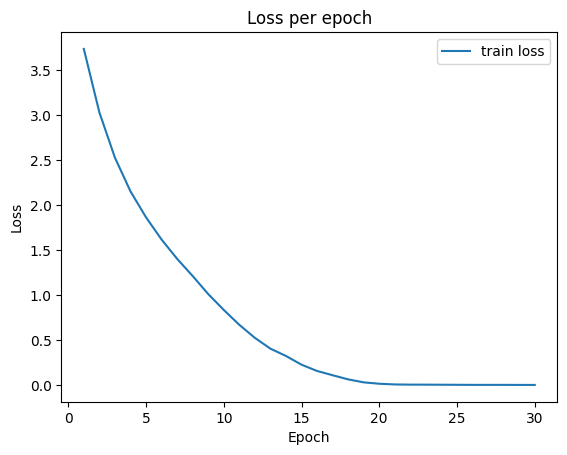

Loss=3.1727, Accuracy=0.5024
CPU times: user 1min 40s, sys: 9.2 s, total: 1min 49s
Wall time: 2min 5s


(3.172663916015625, 0.5024)

In [54]:
%%time
# initialize model
resnet = ResNet(block=CorrectBlock, num_blocks=[1,1,1,1]).to(device)
# define the optimizer
optimizer = torch.optim.SGD(resnet.parameters(), lr=lr_sgd, momentum=momentum_sgd)

# train the CNN
train_losses, valid_losses, valid_accs = fit(model=resnet,
             train_dataloader=train_dataloader,
             valid_dataloader=valid_dataloader,
             optimizer=optimizer,
             epochs=30,
             device=device
             )
plot_losses(train_losses)

predict(
    resnet,
    dataloader=valid_dataloader,
    device=device
)




Epoch 0: Train Loss=3.6161, Validation Loss=3.3416, Validation acc=0.1836
Epoch 1: Train Loss=2.7793, Validation Loss=2.6359, Validation acc=0.3304
Epoch 2: Train Loss=2.2879, Validation Loss=2.3387, Validation acc=0.3916
Epoch 3: Train Loss=1.9619, Validation Loss=2.0207, Validation acc=0.4484
Epoch 4: Train Loss=1.7054, Validation Loss=1.9653, Validation acc=0.4722
Epoch 5: Train Loss=1.4786, Validation Loss=1.9381, Validation acc=0.4788
Epoch 6: Train Loss=1.2696, Validation Loss=1.9365, Validation acc=0.4846
Epoch 7: Train Loss=1.0697, Validation Loss=2.0935, Validation acc=0.4790
Epoch 8: Train Loss=0.8807, Validation Loss=2.1118, Validation acc=0.4834
Epoch 9: Train Loss=0.7217, Validation Loss=2.2298, Validation acc=0.4770
Epoch 10: Train Loss=0.5849, Validation Loss=2.3617, Validation acc=0.4738
Epoch 11: Train Loss=0.4745, Validation Loss=2.4898, Validation acc=0.4686
Epoch 12: Train Loss=0.3982, Validation Loss=2.5890, Validation acc=0.4756
Epoch 13: Train Loss=0.3343, Valida

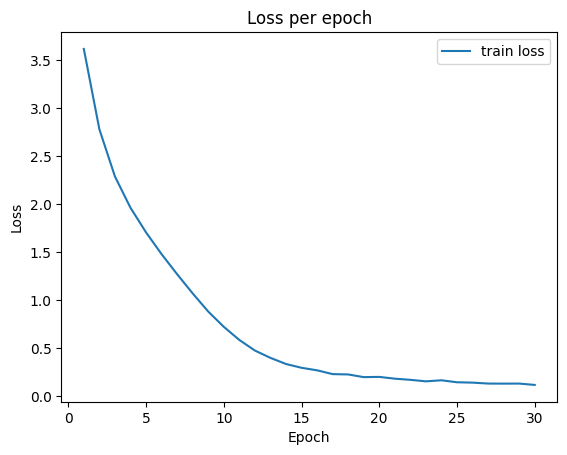

Loss=3.6634, Accuracy=0.4634
CPU times: user 4min 54s, sys: 18.3 s, total: 5min 12s
Wall time: 5min 34s


(3.6634025390625, 0.4634)

In [56]:
%%time
# initialize model
resnet = ResNet(block=CorrectBlock, num_blocks=[1,1,1,1]).to(device)
# define the optimizer
optimizer = torch.optim.Adam(resnet.parameters(), lr=lr_adam)

# train the CNN
train_losses, valid_losses, valid_accs = fit(model=resnet,
             train_dataloader=train_dataloader_adam,
             valid_dataloader=valid_dataloader,
             optimizer=optimizer,
             epochs=30,
             device=device
             )
plot_losses(train_losses)

predict(
    resnet,
    dataloader=valid_dataloader,
    device=device
)

### Observation with this architecture of ResNet

We observe that, under our time and compute constraints, fine-tuning the usual hyperparameters (learning rate, batch size, scheduler) leads to a performance plateau. Before increasing the model capacity, we will first try **AdamW** as an optimizer, since it combines the fast and stable optimization behavior of Adam with **decoupled weight decay**, which is a more appropriate form of regularization for Adam-style methods and can improve generalization compared to using Adam with an L2 penalty. This choice is motivated by the fact that optimizer dynamics can significantly affect convergence and final accuracy, especially when training budgets are limited ([Decoupled Weight Decay Regularization / AdamW](https://arxiv.org/abs/1711.05101)).

If the plateau persists, the good news is that we still have roughly **300,000 parameters** available in our budget. In that case, a natural architectural improvement is to make the ResNet **deeper** (adding more blocks). Increasing depth is a parameter-efficient way to increase representation power, and it is particularly cost-effective in later stages where the spatial resolution is smaller, meaning we obtain more semantic processing per parameter.

In [59]:
# Grid of Hyperparameters

learning_rates_adaw = [1e-4,3e-4,5e-4,1e-3]
batch_sizes_adaw =  [32,64,128]

In [60]:
%%time
# Let's run cross validation on the three components for AdamW :
for l_r in learning_rates_adaw:
    for b_s in batch_sizes_adaw:

      # define the hyperparameters
      BATCH_SIZE = b_s
      TEST_BATCH_SIZE = 1024
      LEARNING_RATE = l_r


      train_dataloader = DataLoader(
          dataset=train_dataset,
          batch_size=BATCH_SIZE,
          shuffle=True,
          num_workers=2)

      valid_dataloader = DataLoader(
            dataset=valid_dataset,
            batch_size=TEST_BATCH_SIZE,
            shuffle=False,
            num_workers=2)


      print(f"Training with learning rate = {l_r} and batch_size={b_s} with AdamW ")

      # initialize model
      resnet = ResNet(block=CorrectBlock, num_blocks=[1,1,1,1]).to(device)
      # define the optimizer
      optimizer = torch.optim.AdamW(resnet.parameters(), lr=l_r)

      # train the CNN
      losses = fit(
             model=resnet,
             train_dataloader=train_dataloader,
             valid_dataloader=valid_dataloader,
             optimizer=optimizer,
             epochs=6,
             device=device
             )


      print("***********************************************************")
      print("***********************************************************")
      print("***********************************************************")

Training with learning rate = 0.0001 and batch_size=32 with AdamW 
Epoch 0: Train Loss=3.9559, Validation Loss=3.5683, Validation acc=0.1716
Epoch 1: Train Loss=3.4218, Validation Loss=3.1719, Validation acc=0.2360
Epoch 2: Train Loss=3.0542, Validation Loss=2.8687, Validation acc=0.2962
Epoch 3: Train Loss=2.7572, Validation Loss=2.6531, Validation acc=0.3292
Epoch 4: Train Loss=2.5155, Validation Loss=2.4836, Validation acc=0.3656
Epoch 5: Train Loss=2.3067, Validation Loss=2.4338, Validation acc=0.3772
***********************************************************
***********************************************************
***********************************************************
Training with learning rate = 0.0001 and batch_size=64 with AdamW 
Epoch 0: Train Loss=4.0264, Validation Loss=3.6995, Validation acc=0.1424
Epoch 1: Train Loss=3.5181, Validation Loss=3.3343, Validation acc=0.2118
Epoch 2: Train Loss=3.2065, Validation Loss=3.0550, Validation acc=0.2636
Epoch 3: Train Loss=

For AdamW : It seems that we have the best results for training with learning rate = 0.0003 and batch size = 32.

In [65]:
learning_rate_Adaw = 5e-4
batch_size_Adaw = 32


train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size= batch_size_Adaw,
    shuffle=True,
    num_workers=2)

valid_dataloader = DataLoader(
    dataset=valid_dataset,
    batch_size=TEST_BATCH_SIZE,
    shuffle=False,
    num_workers=2)

test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=TEST_BATCH_SIZE,
    shuffle=False,
    num_workers=2)

Epoch 0: Train Loss=3.6341, Validation Loss=3.1303, Validation acc=0.2278
Epoch 1: Train Loss=2.8109, Validation Loss=2.7912, Validation acc=0.2906
Epoch 2: Train Loss=2.3441, Validation Loss=2.2500, Validation acc=0.3948
Epoch 3: Train Loss=2.0270, Validation Loss=2.1702, Validation acc=0.4260
Epoch 4: Train Loss=1.7816, Validation Loss=2.0160, Validation acc=0.4564
Epoch 5: Train Loss=1.5691, Validation Loss=1.9023, Validation acc=0.4786
Epoch 6: Train Loss=1.3721, Validation Loss=1.9725, Validation acc=0.4758
Epoch 7: Train Loss=1.1848, Validation Loss=1.9425, Validation acc=0.4804
Epoch 8: Train Loss=1.0105, Validation Loss=1.9521, Validation acc=0.4830
Epoch 9: Train Loss=0.8528, Validation Loss=1.9872, Validation acc=0.4942
Epoch 10: Train Loss=0.7021, Validation Loss=2.1008, Validation acc=0.4920
Epoch 11: Train Loss=0.5869, Validation Loss=2.1657, Validation acc=0.4876
Epoch 12: Train Loss=0.4765, Validation Loss=2.3035, Validation acc=0.4656
Epoch 13: Train Loss=0.4073, Valida

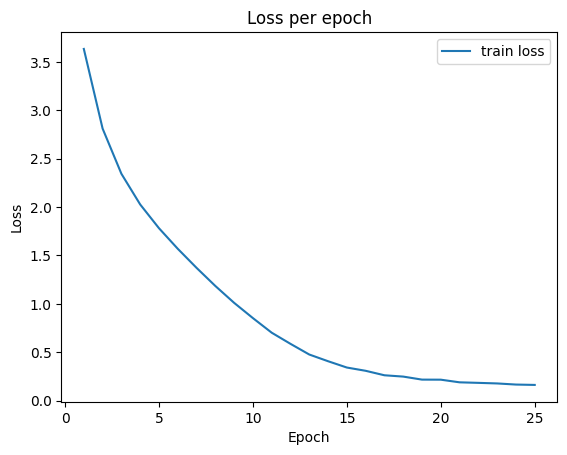

Loss=3.0886, Accuracy=0.4544
CPU times: user 4min 21s, sys: 15.6 s, total: 4min 36s
Wall time: 4min 55s


(3.088555224609375, 0.4544)

In [67]:
# Trying with AdamW

%%time
# initialize model
resnet = ResNet(block=CorrectBlock, num_blocks=[1,1,1,1]).to(device)
# define the optimizer
optimizer = torch.optim.AdamW(resnet.parameters(), lr=learning_rate_Adaw)

# train the CNN
train_losses, valid_losses, valid_accs = fit(model=resnet,
             train_dataloader=train_dataloader,
             valid_dataloader=valid_dataloader,
             optimizer=optimizer,
             epochs=25,
             device=device
             )
plot_losses(train_losses)

predict(
    resnet,
    dataloader=valid_dataloader,
    device=device
)

Across the three optimizers we tested (SGD, Adam, and AdamW), the training curves show the same pattern: the **training loss keeps decreasing to very small values**, while the **validation loss starts increasing** and the validation accuracy saturates or decreases after the first epochs. This behavior is a clear sign of **overfitting** : the model is increasingly memorizing the training set, but this does not translate into better generalization on unseen data.

A key reason this happens is that, once the model has learned the “easy” structure of the dataset, continuing training with an unchanged or poorly adapted learning rate allows the optimizer to keep fitting finer and finer details (including noise and dataset-specific artifacts). As a result, the model keeps improving on the training set but drifts away from parameters that generalize well, which is reflected by rising validation loss and stagnating validation accuracy.

To address this, we propose using a **learning-rate scheduler**. The motivation is that training typically benefits from two phases:
- **Exploration phase (early training):** a relatively higher learning rate helps the optimizer move quickly and avoid getting trapped in narrow or suboptimal regions.
- **Refinement phase (later training):** gradually reducing the learning rate makes updates smaller and more stable, which helps the model converge to a smoother solution and often improves generalization.


For our experiments, we therefore introduce a scheduler , expecting it to stabilize late training and improve validation performance under the same parameter and compute constraints.

### Improved Optimizer with Scheduler

In [81]:
train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size= 64,
    shuffle=True,
    num_workers=2)

valid_dataloader = DataLoader(
    dataset=valid_dataset,
    batch_size=TEST_BATCH_SIZE,
    shuffle=False,
    num_workers=2)

test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=TEST_BATCH_SIZE,
    shuffle=False,
    num_workers=2)

Epoch 0: Train Loss=3.8394, Validation Loss=3.4422, Validation acc=0.1778
Epoch 1: Train Loss=3.1525, Validation Loss=2.9839, Validation acc=0.2576
Epoch 2: Train Loss=2.7263, Validation Loss=2.7235, Validation acc=0.3088
Epoch 3: Train Loss=2.3450, Validation Loss=2.4606, Validation acc=0.3620
Epoch 4: Train Loss=2.0323, Validation Loss=2.2872, Validation acc=0.4108
Epoch 5: Train Loss=1.7702, Validation Loss=2.2309, Validation acc=0.4352
Epoch 6: Train Loss=1.5319, Validation Loss=2.2186, Validation acc=0.4382
Epoch 7: Train Loss=1.3069, Validation Loss=2.2927, Validation acc=0.4494
Epoch 8: Train Loss=1.0999, Validation Loss=2.2355, Validation acc=0.4442
Epoch 9: Train Loss=0.9065, Validation Loss=2.3390, Validation acc=0.4554
Epoch 10: Train Loss=0.7302, Validation Loss=2.6038, Validation acc=0.4440
Epoch 11: Train Loss=0.5834, Validation Loss=2.7840, Validation acc=0.4358
Epoch 12: Train Loss=0.4734, Validation Loss=2.8824, Validation acc=0.4416
Epoch 13: Train Loss=0.3929, Valida

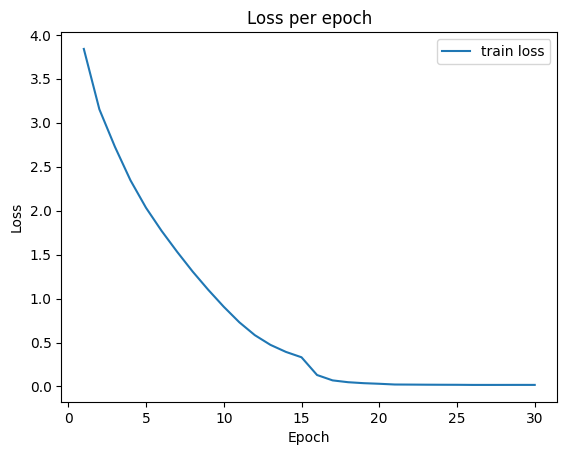

Loss=3.2316, Accuracy=0.4830
CPU times: user 2min 43s, sys: 12.1 s, total: 2min 56s
Wall time: 3min 14s


(3.231585595703125, 0.483)

In [85]:
# define the optimizer
%%time

# initialize model
resnet_schedule = ResNet(block=CorrectBlock, num_blocks=[1,1,1,1]).to(device)

optimizer = torch.optim.Adam(resnet_schedule.parameters(), lr=0.01)


scheduler = torch.optim.lr_scheduler.MultiStepLR(
    optimizer,
    milestones=[15, 20,25],
    gamma=0.1,
)

# train the CNN
train_losses, valid_losses, valid_accs = fit(model=resnet_schedule,
             train_dataloader=train_dataloader,
             optimizer=optimizer,
             epochs=30,
            device=device,
            valid_dataloader=valid_dataloader,
            scheduler = scheduler
             )
plot_losses(train_losses)

predict(
    resnet_schedule,
    dataloader=valid_dataloader,
    device=device

)

### Final Try : Deeper Architecture

It looks like we are again facing an overfitting issue: the model continues to improve on the training set, while the validation performance stops improving or degrades. One possible approach is to increase the depth of the network by adding more residual blocks. This increases the model’s representational capacity and allows it to learn richer hierarchical features; in particular, adding blocks in the later stages (where feature maps are smaller) is parameter-efficient and typically provides more high-level semantic processing per parameter, which can help improve overall performance.

In [97]:
class CorrectBlock(nn.Module):

    def __init__(self, in_planes, planes, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):

        identity = x                         # save original input

        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        shortcut = self.shortcut(identity)   # apply shortcut to original x
        out = out + shortcut                 # residual addition
        out = F.relu(out)


        return out


class DeeperResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=100, base=32, max_planes=126):
        super().__init__()
        self.in_planes = base

        self.conv1 = nn.Conv2d(3, base, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(base)

        # widths: base, 2*base, 4*base, 8*base but capped
        widths = [base, min(2*base, max_planes), min(4*base, max_planes), min(8*base, max_planes)]

        self.layer1 = self._make_layer(block, widths[0], num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, widths[1], num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, widths[2], num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, widths[3], num_blocks[3], stride=2)

        self.fc = nn.Linear(widths[3], num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for s in strides:
            layers.append(block(self.in_planes, planes, s))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        out = F.adaptive_avg_pool2d(out, 1)   # (B, C, 1, 1)
        out = torch.flatten(out, 1)           # (B, C)
        out = self.fc(out)
        return out

print("Model parameters: ", sum(p.numel() for p in DeeperResNet(block=CorrectBlock, num_blocks=[2,2,2,1]).parameters()))

Model parameters:  995412


Epoch 0: Train Loss=3.8821, Validation Loss=3.5244, Validation acc=0.1568
Epoch 1: Train Loss=3.1400, Validation Loss=2.9272, Validation acc=0.2724
Epoch 2: Train Loss=2.6510, Validation Loss=2.6112, Validation acc=0.3398
Epoch 3: Train Loss=2.2583, Validation Loss=2.6239, Validation acc=0.3468
Epoch 4: Train Loss=1.9410, Validation Loss=2.3347, Validation acc=0.3988
Epoch 5: Train Loss=1.4031, Validation Loss=1.9452, Validation acc=0.4832
Epoch 6: Train Loss=1.2454, Validation Loss=1.9445, Validation acc=0.4838
Epoch 7: Train Loss=1.1448, Validation Loss=1.9607, Validation acc=0.4834
Epoch 8: Train Loss=1.0533, Validation Loss=1.9746, Validation acc=0.4874
Epoch 9: Train Loss=0.9698, Validation Loss=1.9958, Validation acc=0.4844
Epoch 10: Train Loss=0.8529, Validation Loss=1.9949, Validation acc=0.4878
Epoch 11: Train Loss=0.8382, Validation Loss=1.9904, Validation acc=0.4894
Epoch 12: Train Loss=0.8279, Validation Loss=2.0045, Validation acc=0.4912
Epoch 13: Train Loss=0.8195, Valida

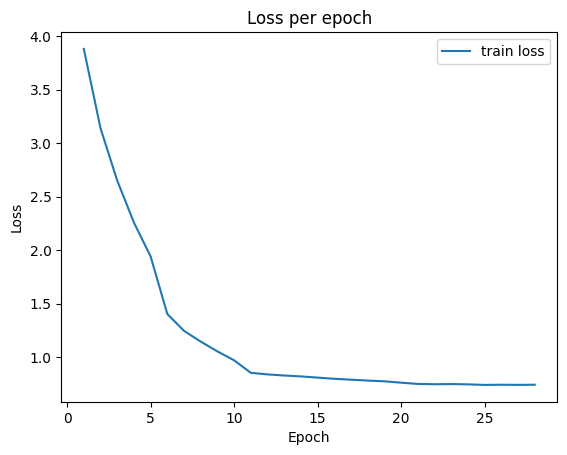

Loss=2.0223, Accuracy=0.4914
CPU times: user 3min 46s, sys: 11.7 s, total: 3min 58s
Wall time: 4min 14s


(2.0223456298828126, 0.4914)

In [99]:
%%time
# initialize model
deepresnet = DeeperResNet(block=CorrectBlock, num_blocks=[2,2,2,1]).to(device)

optimizer = torch.optim.Adam(deepresnet.parameters(), lr=0.01)


scheduler = torch.optim.lr_scheduler.MultiStepLR(
    optimizer,
    milestones=[5,10,20],
    gamma=0.1,
)

# train the CNN
train_losses, valid_losses, valid_accs = fit(model=deepresnet,
             train_dataloader=train_dataloader,
             optimizer=optimizer,
             epochs=30,
            device=device,
            valid_dataloader=valid_dataloader,
            scheduler = scheduler
             )
plot_losses(train_losses)

predict(
    deepresnet,
    dataloader=valid_dataloader,
    device=device
)


In [100]:
# save the model on a file
torch.save(deepresnet.state_dict(), 'deepres_net.pt')

loaded_model_1 = DeeperResNet(block=CorrectBlock, num_blocks=[2,2,2,1])
loaded_model_1.load_state_dict(torch.load('deepres_net.pt', weights_only=True))
evaluate(loaded_model_1)

The model has 995412 parameters
Accuracy on the test set: 50.25%
